## Pipeline 

Main goal. Pipeline skeleton to:
1. Classify households according to some grouping
2. Compute TV metrics
3. Testing sample size methodologies


Pipeline structure
1. Send relevant info to filter crosswalk-eventlog data (client, week for crosswalk, campaign dates, etc)
2. Creating base data frame with ctrl group and visited flags
3. Append fake demographic data 
4. Create new variables (brackets from census and experian)
5. Calculate metrics and choose variables to group data set
6. Sample sizes analysis (100 samples of total data)

In [ ]:
import os
currentdir = os.getcwd()
correctdir = currentdir.rsplit('tv2ds/',1)[0]
os.chdir(correctdir)

from tv2ds.ds_lib import notebook_prodrun
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
from datetime import datetime, timedelta
import tvsquared.settings
from tvsquared.lib.request import Request
from tvsquared.lib.athena import AthenaDatabase
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_colwidth', None)

In [ ]:
notebook_prodrun.set_env('US', prodrunenv='PROD')
crosswalk_suffix = os.environ.get('TV2PRODRUNENV').lower()
crosswalk_suffix

'produsa'

In [ ]:
def make_request(clientid, brandid = 1, datefrom=False, dateto=False):
    # Helper Function to make a request from client, brand, and date range arguments
    # Returns the request object
    if datefrom and dateto:
        request = Request(clientarg=False, brandarg=False, datesarg=False)
        datefrom = datetime.datetime.strptime(datefrom, '%Y-%m-%d')
        dateto = datetime.datetime.strptime(dateto, '%Y-%m-%d')
        request = request.init(partnerid=None, clientid=clientid, brandid=brandid,datefrom=datefrom, dateto=dateto,loglevel=-1, extargs=None, request=None, usespark=None, readPreference=None,prodrun=False)
        return(request)
    else:
        request = Request(clientarg=False, brandarg=False, datesarg=False)
        request = request.init(partnerid=None, clientid=clientid, brandid=brandid,datefrom=None, dateto=None,loglevel=-1, extargs=None, request=None, usespark=None, readPreference=None,prodrun=False)
        return(request)


def query_athena(request, query, copy_to_local=False):
    athena_db = AthenaDatabase.get_client_database(request)
    query_results = AthenaDatabase.execute_query(athena_db, query, copy_to_local=copy_to_local)
    df = pd.DataFrame(query_results)
    return(df)

In [ ]:
client = {'clientid': 9306}
request = make_request(client['clientid'])

## ✅️ Step1. Send relevant info to filter crosswalk-eventlog data

🚨 Why are my "visited" variables not being populated properly??<br/> <br/>
When bringin back results python reads the data as object so need to add: <br/> 
```python
df_control_pday= query_athena(
    request, 
    query_control_perday(
        subquery_name='hh_control_perday',
        yy_value=yy_input, mm_value=mm_input,dd_value=dd_input,
        dateto_value=dateto_input, 
        datefrom_value=datefrom_input,  
        clientid_value=clientid_input,
        )).astype({"ctrl_hhs": "int"}) #--> need to use this for the previous code when I tried bringing flags directly from Athena, this was the problem
```
        
dont know why but I fixed it and instead have done the creation of these flag in python and added ctrl_flag as well to distinguish between data that came from CG and data that came from exposed grp.

### ➡️ Client and information used to extract sample data:
**Drizly**<br>
vendor_name='inscape', yy='2022', mm='03',dd='28',crosswalk_suffix='produsa',dateto='2022-03-31', datefrom='2022-03-01', clientid='c9306_drizly'<br>

**Therealreal**<br>
vendor_name='inscape', yy='2022', mm='01',dd='24',crosswalk_suffix='produsa',dateto='2022-01-30', datefrom='2022-01-01', clientid='c9534_uti'<br>

**Uti**<br>
vendor_name='inscape', yy='2022', mm='01',dd='24',crosswalk_suffix='produsa',dateto='2022-01-30', datefrom='2022-01-01', clientid='9534'<br>

In [ ]:
# Inputs needed for queries in Athena

yy_input='2022' 
mm_input='03'
dd_input='28'
dateto_input='2022-03-31' 
datefrom_input='2022-03-01'  
lookback_window_input=30
# clientid_input='c9306_drizly'
# clientid_input='c9534_uti'
clientid_input='c16319_the_realreal'

### ➡️ Control data set

In [ ]:
def query_control(subquery_name: str, yy_value:str, mm_value:str, dd_value:str, dateto_value:str, datefrom_value:str, clientid_value:str): 
   return '''
   with filtered_hh as (
   select 
        key_value as mapped_tv2_hhid
   from {crosswalk_suffix}_modeldata.crosswalk
   where 
        yy='{yy}' 
        and mm='{mm}' 
        and dd='{dd}'
        and key_name ='tv2_hhid' 
        and vendor_name = '{vendor_name}'
        and excluded_stamp is null
   ),
   campaign_universe as (
      select 
         complex_ranges.mapped_tv2_hhid 
      FROM {crosswalk_suffix}_modeldata.crosswalk cw
      CROSS JOIN UNNEST(complex_range) AS t (complex_ranges)
      join filtered_hh fh on fh.mapped_tv2_hhid = complex_ranges.mapped_tv2_hhid
      where 
         vendor_name = '{vendor_name}'
         and complex_ranges.first_seen <= timestamp '{dateto}' + interval '1' day
         and complex_ranges.last_seen >= timestamp '{datefrom}' 
         and key_name = 'tv2_hhid'
         and yy='{yy}'
         and mm='{mm}' 
         and dd='{dd}'
   ),
   client_eventlog as (
      select 
      *
      from {clientid}_{crosswalk_suffix}.eventlog
      where 
         datadatetime between timestamp '{datefrom}' 
         and timestamp '{dateto}' + interval '7' day
   ),
   hh_impressed_30days as (
      select
         distinct crosswalk_link_id as mapped_tv2_hhid
      from campaign_universe ex
      join client_eventlog ev on ev.crosswalk_link_id = ex.mapped_tv2_hhid
      where
         event_class='impression'
         and datadatetime between timestamp '{datefrom}' - interval '30' day    
         and timestamp '{dateto}' + interval '1' day + interval '6' day
         and in_scope
   ),
   hh_control as (
      select
         distinct cu.mapped_tv2_hhid
      from campaign_universe cu
      left join hh_impressed_30days hh on hh.mapped_tv2_hhid  = cu.mapped_tv2_hhid
      where hh.mapped_tv2_hhid is null
   ),
   n_hh_control_visited as (
      select distinct 
         mapped_tv2_hhid
      from client_eventlog
      join hh_control on crosswalk_link_id = mapped_tv2_hhid
      where
         event_class ='response' and event= 'all response'
         and datadatetime between timestamp '{datefrom}' 
         and timestamp '{dateto}' + interval '6' day + interval '1' day
         and in_scope in (TRUE, null)
   ),
   hh_control_visited as (
      select
         ctrl.mapped_tv2_hhid 
         ,(case when visited.mapped_tv2_hhid is not null then 1 else 0 end) as visited 
      from hh_control ctrl
      left join n_hh_control_visited visited on ctrl.mapped_tv2_hhid = visited.mapped_tv2_hhid
   )
   select
      *
   from {result}

'''.format(
   vendor_name='inscape', 
   yy=yy_value, mm=mm_value,dd=dd_value,
   crosswalk_suffix='produsa',
   dateto=dateto_value, 
   datefrom=datefrom_value,  
   clientid=clientid_value,
   result=subquery_name
   )   

#### ➜ All control hhs

In [ ]:
#--> 39m to run, modify query so that query_control brings back hh_control
df_control= query_athena(
    request, 
    query_control(
        subquery_name='hh_control',
        yy_value=yy_input, mm_value=mm_input,dd_value=dd_input,
        dateto_value=dateto_input, 
        datefrom_value=datefrom_input,  
        clientid_value=clientid_input,
    )) 

In [ ]:
df_control.shape 

(7034376, 1)

In [ ]:
df_control.head()

#### ➜ Control visited

In [ ]:
#--> 5m aprox to run, modify query so that query_control brings back n_hh_control_visited
df_control_visited= query_athena(
    request, 
    query_control(
        subquery_name='n_hh_control_visited',
        yy_value=yy_input, mm_value=mm_input,dd_value=dd_input,
        dateto_value=dateto_input, 
        datefrom_value=datefrom_input,  
        clientid_value=clientid_input,
    ))  

In [ ]:
df_control_visited.shape

(69973, 1)

In [ ]:
df_control_visited.head()

In [ ]:
df_control_visited=df_control_visited.assign(visited = 1)

In [ ]:
df_control=df_control.merge(df_control_visited, how='left', on=['mapped_tv2_hhid'])
df_control['visited'].fillna(0, inplace=True)
df_control=df_control.astype({"visited": int})

In [ ]:
df_control.head()
# df_control[df_control['visited']==1].head(5)

In [ ]:
df_control.visited.sum()

69973

In [ ]:
print(df_control.shape)

(7034376, 2)


### ➡️ Exposed data set

In [ ]:
def query_exposed(subquery_name: str, yy_value:str, mm_value:str, dd_value:str, dateto_value:str, datefrom_value:str, clientid_value:str):
   return '''
   with filtered_hh as (
   select 
        key_value as mapped_tv2_hhid
   from {crosswalk_suffix}_modeldata.crosswalk
   where 
        yy='{yy}' 
        and mm='{mm}' 
        and dd='{dd}'
        and key_name ='tv2_hhid' 
        and vendor_name = '{vendor_name}'
        and excluded_stamp is null
   ),
   campaign_universe as (
      select 
         complex_ranges.mapped_tv2_hhid 
      FROM {crosswalk_suffix}_modeldata.crosswalk cw
      CROSS JOIN UNNEST(complex_range) AS t (complex_ranges)
      join filtered_hh fh on fh.mapped_tv2_hhid = complex_ranges.mapped_tv2_hhid
      where 
         vendor_name = '{vendor_name}'
         and complex_ranges.first_seen <= timestamp '{dateto}' + interval '1' day
         and complex_ranges.last_seen >= timestamp '{datefrom}' 
         and key_name = 'tv2_hhid'
         and yy='{yy}'
         and mm='{mm}' 
         and dd='{dd}'
   ),
   client_eventlog as (
      select 
      *
      from {clientid}_{crosswalk_suffix}.eventlog
      where 
         datadatetime between timestamp '{datefrom}' 
         and timestamp '{dateto}' + interval '7' day
   ),
   hh_impressed_in_campaign as (
      select
         distinct crosswalk_link_id as mapped_tv2_hhid
      from campaign_universe ex
      join client_eventlog ev on ev.crosswalk_link_id = ex.mapped_tv2_hhid
      where
         event_class='impression'
         and event = 'linear'
         and datadatetime between timestamp '{datefrom}' 
         and timestamp '{dateto}' + interval '1' day
         and in_scope
   ),
   n_hh_impressed_visited as (
      select distinct 
         mapped_tv2_hhid
      from client_eventlog
      join hh_impressed_in_campaign on crosswalk_link_id = mapped_tv2_hhid
      where
         event_class ='response' and event= 'all response'
         and datadatetime between timestamp '{datefrom}' 
         and timestamp '{dateto}' + interval '6' day + interval '1' day
         and in_scope in (TRUE, null)
   ),
   hh_impressed_visited as (
      select
         impressed.mapped_tv2_hhid 
         ,(case when visited.mapped_tv2_hhid is not null then 1 else 0 end) as visited 
      from hh_impressed_in_campaign impressed
      left join n_hh_impressed_visited visited on impressed.mapped_tv2_hhid = visited.mapped_tv2_hhid
   ),
   n_visited_impressed as (
      select SUM(visited) as exp_visited
      from hh_impressed_visited
   ),
   n_hh_impressed as (
      select CAST(count(distinct mapped_tv2_hhid) AS double) as exp_hh
      from hh_impressed_visited
   ),
   final_results as (
      select *
      from n_hh_impressed
      cross join n_visited_impressed
   )
   select
      *
   from {result}

'''.format(
   vendor_name='inscape', 
   yy=yy_value, mm=mm_value,dd=dd_value,
   crosswalk_suffix='produsa',
   dateto=dateto_value, 
   datefrom=datefrom_value,  
   clientid=clientid_value,
   result=subquery_name
   )   

#### ➜ All exposed hhs

In [ ]:
#--> 5m modify query so that query_exposed_march brings back hh_impressed_in_campaign
df_exposed= query_athena(
    request, 
    query_exposed(
        subquery_name='hh_impressed_in_campaign',
        yy_value=yy_input, mm_value=mm_input,dd_value=dd_input,
        dateto_value=dateto_input, 
        datefrom_value=datefrom_input,  
        clientid_value=clientid_input,
    )) 

In [ ]:
df_exposed.shape 

(1372587, 1)

#### ➜ Exposed visited

In [ ]:
#--> 28s modify query so that query_exposed_march brings back n_hh_impressed_visited
df_exposed_visited= query_athena(
    request,
    query_exposed(
        subquery_name='n_hh_impressed_visited',
        yy_value=yy_input, mm_value=mm_input,dd_value=dd_input,
        dateto_value=dateto_input, 
        datefrom_value=datefrom_input,  
        clientid_value=clientid_input,
    ))  

In [ ]:
df_exposed_visited.shape

(31328, 1)

In [ ]:
df_exposed_visited=df_exposed_visited.assign(visited = 1)

In [ ]:
df_exposed=df_exposed.merge(df_exposed_visited, how='left', on=['mapped_tv2_hhid'])
df_exposed['visited'].fillna(0, inplace=True)
df_exposed=df_exposed.astype({"visited": int})

In [ ]:
df_exposed[df_exposed['visited']==1].head(5)

In [ ]:
df_exposed.visited.sum()

31328

Creating visited flag for exposed df - final exposed tables: 
- **df_exposed**: campaign level information

In [ ]:
df_exposed.shape

(1372587, 2)

## ✅️ Step2. Creating base data frame with ctrl group and visited flags

### Creating flags and merging the 2 data sets (ctrl and exposed)
- control group flag: This indicates if a hh belongs to the control group or not
- visited flag: Indicates if a hh visited the clients website on the time frame specified. <br> 
From sql query: <br> 
    (event_class ='response' and event= 'all response' <br> 
       and datadatetime between timestamp '{datefrom}' and timestamp '{dateto}' + interval '6' day + interval '1' day <br> 
       and in_scope)

#### ➜ Campaign level data sets

In [ ]:
df_control=df_control.assign(ctrl_flag = 1)
df_exposed=df_exposed.assign(ctrl_flag = 0)
base_df=pd.concat([df_control, df_exposed], axis=0)

# for function?: if the name has control add column with 1s
# else if the name has exposed column values have 0
# add ctrl flag to data set


In [ ]:
base_df.head()

In [ ]:
num_hhid = len(base_df)
num_hhid

8406963

## ✅️ Step3. Append fake demographic data

In [ ]:
df = base_df.assign(
    age=np.random.randint(18, 90, size=num_hhid), # only adults as  head of HH - assuming individual variables are at head of HH only
    gender=np.random.choice(['Male', 'Female','Unknown'], num_hhid), 
    number_of_children=np.random.randint(0, 8, num_hhid),
    number_of_people=np.random.randint(1, 8, num_hhid),
    household_income=np.random.randint(8000, 400000, num_hhid),
    under18_flag=lambda df: np.where(df['number_of_children']>0, 1, 0)
)

In [ ]:
# df=df.assign(under18_flag = np.where(df['number_of_children']>0, 1, 0)) 
# update 14sep: this flag is now included in the upper cell
df[df['number_of_children'] == 0].head()

In [ ]:
# ad-hoc fix of fake df - fixing number of people > number of children 
df["number_of_people"] = (
    df["number_of_people"]
    .where(
        df['number_of_children'] < df['number_of_people'], 
        df['number_of_children']+2
    )
)

In [ ]:
# ad-hoc fix of fake df - fixing if number_of_children = 0 => age > = 18 
# update 06Sept: Age is now only >18 so this in theory does not need to be fixed anymore

# df["age"] = (
#     df["age"]
#     .where(
#         df['number_of_children'] > 0, 
#         np.random.randint(18, 101, len(df))
#     )
# )

In [ ]:
df[df['number_of_children'] == 0].head()

## ✅️ Step4. Create new variables (brackets from census and experian)

### Functions for grouping, brackets and new variables

In [ ]:
def cut(source_column_name: str, target_column_name: str, bins: list, labels: list):
    def pipe(df: pd.DataFrame):
        return df.assign(
            **{target_column_name: pd.cut(df[source_column_name], bins, right=False, labels=labels, include_lowest=True).fillna(labels[-1])}
        )
    return pipe

#Align age brackets to Census data
add_age_bins = cut(
    source_column_name="age", 
    target_column_name="age_range", 
    bins=[0, 18, 25, 35, 45, 55, 65, 75, 200],
    labels=['under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
)

#Align income brackets to Experian data
add_income_brackets = cut(
    source_column_name="household_income", 
    target_column_name="hhincome_range", 
    bins=[0, 15000, 25000, 35000, 50000, 75000, 100000, 125000, 150000, 200000, 500000],
    labels=['Less than 15k', '[15-25k)', '[25-35k)', '[35-50k)', '[50-75k)', '[75-100k)', '[100-125k)', '[125-150k)', '(150-200k)','[200+']
)

# Higher income roll-up for grouping with hh_composition
add_wealth = cut(
    source_column_name="household_income", 
    target_column_name="hh_wealth", 
    bins=[0, 15000, 35000, 75000, 125000, 500000],
    labels=['Less than 15k', '[15-35k)', '[35-75k)', '[75-125k)', '[125k+']
)

#Life stage variable
add_lifestage_var = cut(
    source_column_name="age", 
    target_column_name="life_stage", 
    bins=[0, 18, 25, 55, 200],
    labels=['under 18', 'young adult', 'adult', 'senior']
    # bins=[0, 18, 25, 35, 45, 55, 65, 75, 200],
    # labels=['under 18', 'young adult', 'young professionals', 'professionals', 'middle aged', 'young seniors', 'senior', 'elderly']
)

In [ ]:
def add_composition(target_column: str, number_of_people_column: str = "number_of_people", number_of_children_column: str = "number_of_children"):
    def pipe(df: pd.DataFrame):
        return df.assign(**{
            target_column: np.where(
                df[number_of_children_column] > 0, 
                "family",
                pd.cut(
                    df[number_of_people_column], 
                    [1, 2, 3, 4], 
                    right=False, 
                    labels=["single adult", "two adults", "all adults"], 
                    include_lowest=True
                ).fillna("all adults"))
        })
    return pipe



In [ ]:
def add_lifestage_detail(target_column: str, age_column: str = "age", number_of_children_column: str = "number_of_children"):
    def pipe(df: pd.DataFrame):
        return df.assign(**{
            target_column: np.where(
                df[number_of_children_column] > 0, 
                "family life", # maybe add some more age or life stage information about the head of hh
                pd.cut(
                    df[age_column], 
                    [0, 18, 25, 35, 45, 55, 65, 75, 200], 
                    right=False, 
                    labels=['under 18', 'young adult', 'young professionals', 'professionals', 'middle aged', 'young seniors', 'senior', 'elderly'], 
                    include_lowest=True
                )) # do I need to add some fillna here when real data comes in?
        })
    return pipe

In [ ]:
# testing functions
# pd.DataFrame({
#     "age": [17, 17.5, 18, 24, 25, 54, 55, 60],
#     "household_income": [14999.99999, 15000, 35000, 50000, 150000, 200000, 500000, 1000000]
# }).pipe(add_lifestage_var).pipe(add_age_bins).pipe(add_income_brackets)

In [ ]:
# testing function
# pd.DataFrame({
#     "number_of_people": range(1, 10),
#     "number_of_children": [0, 0, 0, 1, 1, 1, 2, 2, 2]
# }).pipe(add_composition(target_column="hh_composition"))

In [ ]:
# testing function
# pd.DataFrame({
#     "age": [17, 17.5, 18, 24, 25, 54, 55, 60, 20],
#     "number_of_children": [0, 0, 0, 0, 1, 1, 0, 2, 0]
# }).pipe(add_lifestage_detail(target_column="hh_detail_life"))

In [ ]:
df_with_ranges = (
    df
    .pipe(add_age_bins)
    .pipe(add_income_brackets)
    .pipe(add_wealth)
    .pipe(add_lifestage_var)
    .pipe(add_composition(target_column="hh_composition"))
    .pipe(add_lifestage_detail(target_column="hh_detail_life"))
    .assign(
        age_gender=lambda df: df.gender + " - " + df.age_range.astype("str"),
        life_gender=lambda df: df.gender + " - " + df.life_stage.astype("str"),
        hh_comp_wealth=lambda df: df.hh_composition + " - " + df.hh_wealth.astype("str"),
    )
)
df_with_ranges.head()

In [ ]:
df_with_ranges.shape

(8406963, 18)

## ✅️ Step5. Calculate metrics and choose variables to group data set 

🚨 To start with I am creating a pivot and graph with hh_composition and hh_comp_wealth but need to put this in a function

### Metrics

Metrics include:
- exp_visited	
- exp_hh	
- ctrl_visited	
- ctrl_hh	
- exp_vr=exp_visited/exp_hh	
- ctrl_vr=ctrl_visited/ctrl_hh 
- uplift=(exp_visited/exp_hh - ctrl_visited/ctrl_hh)/ (ctrl_visited/ctrl_hh)

for March data from Drizly (client 9306)

Crosswalk week: yy='2022', mm='03',dd='28' <br>
Campaing dates: dateto='2022-03-31', datefrom='2022-03-01'

### ➜ Metric and pivot table Functions

In [ ]:
def ctrl_hh_column(df: pd.DataFrame):
    return np.where(df.ctrl_flag==1,1,0)

def ctrl_visited_column(df: pd.DataFrame):
    return np.where((df.ctrl_flag==1) & (df.visited==1),1,0)

def exp_hh_column(df: pd.DataFrame):
    return np.where(df.ctrl_flag==0,1,0)

def exp_visited_column(df: pd.DataFrame):
    return np.where((df.ctrl_flag==0) & (df.visited==1),1,0)

def add_vars_for_metrics(df: pd.DataFrame):
    return df.assign(
        ctrl_hh=ctrl_hh_column,
        ctrl_visited=ctrl_visited_column,
        exp_hh=exp_hh_column,
        exp_visited=exp_visited_column,
    )

In [ ]:
def pivot_table(df: pd.DataFrame, source_column_name: str, margins_value: str):
    table = pd.pivot_table(
        df,
        values=['ctrl_hh', 'ctrl_visited','exp_hh','exp_visited'], 
        index=[source_column_name],
        aggfunc=np.sum,
        margins=margins_value)

    table['ctrl_vr']=table.ctrl_visited/table.ctrl_hh
    table['exp_vr']=table.exp_visited/table.exp_hh
    table['uplift']=(table.exp_visited/table.exp_hh - table.ctrl_visited/table.ctrl_hh)/ (table.ctrl_visited/table.ctrl_hh)
    table['diff_vr']=table.exp_vr - table.ctrl_vr 


    return table

# Way to fix decimal places - need to reset the decimals options for the cell as the global ones are set at the start of the notebook
# decimals = pd.Series([0, 0, 0, 0, 4], index=['ctrl_hh', 'ctrl_visited', 'exp_hh', 'exp_visited', 'ctrl_vr']) 
# table.round(decimals)

### ➜ High level metrics

In [ ]:
overall_metrics_table = pd.DataFrame(
    df_with_ranges
    .pipe(add_vars_for_metrics)
    .pipe(pivot_table, source_column_name='hh_detail_life', margins_value=True)
    .loc['All']
    ).T
overall_metrics_table

,ctrl_hh,ctrl_visited,exp_hh,exp_visited,ctrl_vr,exp_vr,uplift,diff_vr
All,7034376.000000,69973.000000,1372587.000000,31328.000000,0.009947,0.022824,1.294499,0.012877


### ➜ Campaign level metrics

#### Household composition

In [ ]:
hh_composition_table = (
    df_with_ranges
    .pipe(add_vars_for_metrics)
    .pipe(pivot_table, source_column_name='hh_composition', margins_value=False)
    )
hh_composition_table

,ctrl_hh,ctrl_visited,exp_hh,exp_visited,ctrl_vr,exp_vr,uplift,diff_vr
hh_composition,,,,,,,,
all adults,628640,6458,122522,2790,0.010273,0.022771,1.216635,0.012498
family,6154625,61041,1200716,27351,0.009918,0.022779,1.296745,0.012861
single adult,125642,1236,24879,600,0.009837,0.024117,1.451516,0.014279
two adults,125469,1238,24470,587,0.009867,0.023989,1.431196,0.014122


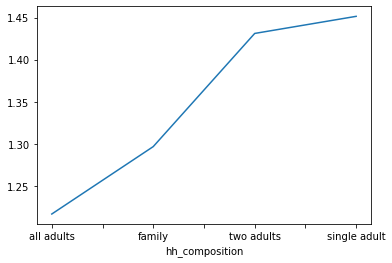

In [ ]:
hh_composition_table.uplift.sort_values().plot(kind='line')
plt.show()

#### Household composition and wealth brackets

In [ ]:
# pivot_table('hh_comp_wealth', True)

#### Life stage (presence of children and age mix)

In [ ]:
hh_detail_life_table = (
    df_with_ranges
    .pipe(add_vars_for_metrics)
    .pipe(pivot_table, source_column_name='hh_detail_life', margins_value=False)
    )
hh_detail_life_table

,ctrl_hh,ctrl_visited,exp_hh,exp_visited,ctrl_vr,exp_vr,uplift,diff_vr
hh_detail_life,,,,,,,,
elderly,183194,1869,35739,816,0.010202,0.022832,1.237947,0.012630
family life,6154625,61041,1200716,27351,0.009918,0.022779,1.296745,0.012861
middle aged,121521,1231,24143,545,0.010130,0.022574,1.228428,0.012444
professionals,122577,1223,23799,574,0.009977,0.024119,1.417329,0.014141
senior,121853,1195,23890,583,0.009807,0.024404,1.488403,0.014597
young adult,85709,901,16517,384,0.010512,0.023249,1.211575,0.012736
young professionals,122507,1251,23984,543,0.010212,0.022640,1.217082,0.012428
young seniors,122390,1262,23799,532,0.010311,0.022354,1.167901,0.012043


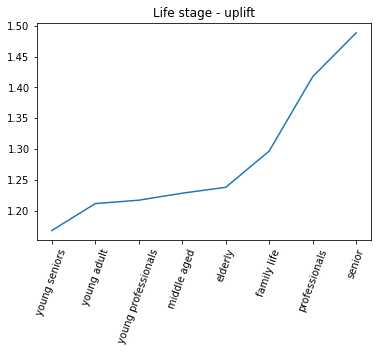

In [ ]:
hh_detail_life_table.uplift.sort_values().plot(kind='line', title='Life stage - uplift', xlabel='')
plt.xticks(rotation = 70)
plt.show()

## ✅️ Step6. Grouping Sample sizes analysis


### Sample size using effect size. 
- Assuming data is normal due to CLT (Bernoulli)
- documentation on the function is not great

In [ ]:
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

# Calculating effect size based on our expected rates (high level vr for control and exposed)
effect_size = sms.proportion_effectsize(0.008023, 0.015955)    

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

2873


### Sampling population for rule of thumb - grouping sample sizes

In [ ]:
#Random sampling

def random_sampling(df, percentage_from_df,random_state_value):
    random_sample = df.sample(frac=percentage_from_df, replace=False, random_state=random_state_value)
    return(random_sample)

#### ➡️ 1 sample for effect on uplift 

In [ ]:
# For reproducibility - random_state=1
randomSample = random_sampling(df_with_ranges, 0.20, random_state_value=1)
randomSample.head()

In [ ]:
randomSample.shape

(1681393, 18)

In [ ]:
hh_composition_sample_df = (
    randomSample
    .pipe(add_vars_for_metrics)
    .pipe(pivot_table, source_column_name='hh_composition', margins_value=True)
    )
hh_composition_sample_df

,ctrl_hh,ctrl_visited,exp_hh,exp_visited,ctrl_vr,exp_vr,uplift,diff_vr
hh_composition,,,,,,,,
all adults,125553,1284,24509,549,0.010227,0.022400,1.190326,0.012173
family,1230959,12179,240332,5530,0.009894,0.023010,1.325656,0.013116
single adult,25316,246,4904,123,0.009717,0.025082,1.581158,0.015364
two adults,24934,232,4886,110,0.009305,0.022513,1.419598,0.013209
All,1406762,13941,274631,6312,0.009910,0.022984,1.319232,0.013074


In [ ]:
hh_detail_life_sample_df = (
    randomSample
    .pipe(add_vars_for_metrics)
    .pipe(pivot_table, source_column_name='hh_detail_life', margins_value=True)
    )
hh_detail_life_sample_df

,ctrl_hh,ctrl_visited,exp_hh,exp_visited,ctrl_vr,exp_vr,uplift,diff_vr
hh_detail_life,,,,,,,,
elderly,36633,359,7226,162,0.009800,0.022419,1.287679,0.012619
family life,1230959,12179,240332,5530,0.009894,0.023010,1.325656,0.013116
middle aged,24362,259,4745,111,0.010631,0.023393,1.200391,0.012762
professionals,24451,253,4789,105,0.010347,0.021925,1.118949,0.011578
senior,24359,246,4785,130,0.010099,0.027168,1.690207,0.017069
young adult,17313,157,3241,76,0.009068,0.023450,1.585873,0.014381
young professionals,24289,238,4821,103,0.009799,0.021365,1.180383,0.011566
young seniors,24396,250,4692,95,0.010248,0.020247,0.975806,0.010000
All,1406762,13941,274631,6312,0.009910,0.022984,1.319232,0.013074


#### ➡️ 100 samples for effect on uplift
can probably put these 3 cells in a function: (passing df_with ranges, sample size and file name for saving)
- step 1: create samples 
- step 2: rename rows
- step 3: save file

In [ ]:
overall_metrics_table

,ctrl_hh,ctrl_visited,exp_hh,exp_visited,ctrl_vr,exp_vr,uplift,diff_vr
All,7034376.000000,69973.000000,1372587.000000,31328.000000,0.009947,0.022824,1.294499,0.012877


In [ ]:
# at the moment this function creates the whole pivot table first but 
# there is probably a more efficent way of calculaing the metrics of the overall sample without creating a pivot table 
dfs=[]
for i in range(100):
    sampled_df=pd.DataFrame(
        random_sampling(df_with_ranges, 0.20, random_state_value=None)
        .pipe(add_vars_for_metrics)
        .pipe(pivot_table, source_column_name='hh_detail_life', margins_value=True)
        .loc['All']
        ).T
    dfs.append(sampled_df)
final_sampled_df = pd.concat(dfs, ignore_index=True)

In [ ]:
final_sampled_df = final_sampled_df.rename(index = lambda x: 'Sample_' + str(x+1))
pd.set_option('display.max_rows', final_sampled_df.shape[0]+1)
final_sampled_df

,ctrl_hh,ctrl_visited,exp_hh,exp_visited,ctrl_vr,exp_vr,uplift,diff_vr
Sample_1,1407151.000000,13952.000000,274242.000000,6214.000000,0.009915,0.022659,1.285291,0.012744
Sample_2,1407271.000000,14129.000000,274122.000000,6266.000000,0.010040,0.022858,1.276737,0.012818
Sample_3,1407411.000000,13989.000000,273982.000000,6173.000000,0.009940,0.022531,1.266776,0.012591
Sample_4,1407385.000000,14151.000000,274008.000000,6237.000000,0.010055,0.022762,1.263801,0.012707
Sample_5,1406291.000000,13827.000000,275102.000000,6231.000000,0.009832,0.022650,1.303622,0.012818
Sample_6,1407309.000000,13969.000000,274084.000000,6136.000000,0.009926,0.022387,1.255412,0.012461
Sample_7,1406516.000000,13959.000000,274877.000000,6179.000000,0.009925,0.022479,1.265010,0.012555
Sample_8,1407310.000000,14036.000000,274083.000000,6273.000000,0.009974,0.022887,1.294772,0.012914
Sample_9,1406408.000000,14154.000000,274985.000000,6264.000000,0.010064,0.022779,1.263471,0.012715
Sample_10,1406438.000000,13973.000000,274955.000000,6276.000000,0.009935,0.022826,1.297483,0.012891


In [ ]:
# Saving 100 sample results
os.getcwd()
final_sampled_df.to_csv('Final_sampled_20perc_Real.csv',index=True)

### Saving parquet files of base DF for reusing later - df name in code: **df_with_ranges**
I didnt use pickle because parquet is more flexible, pickle can create problmes if libraries are updated or new versions arrive and then objects cannot be read anymore

In [ ]:
df_with_ranges.shape

(8406963, 18)

In [ ]:
from pathlib import Path

base_df_location=Path('tv2ds/demographics/control groups/data')
client_name='RealReal_16319_Mar2022_df_with_ranges.parquet'
df_file_name = base_df_location / client_name
df_with_ranges.to_parquet(df_file_name)

In [ ]:
# df_with_ranges=pd.read_parquet(df_file_name)